In [1]:
import yaml
import click
import torch
import tqdm.auto
import numpy as np
from torchvision.models import vit_b_16

from matplotlib import pyplot as plt


import sys
import os
import re
import math
#project_root = "C:/Users/elmop/deep_feature_reweighting/deep_feature_reweighting/external/pruning_by_explaining"
project_root = "/home/primmere/ide/external/pruning_by_explaining"
sys.path.insert(0, project_root)                 
sys.path.insert(0, os.path.dirname(project_root))

from pruning_by_explaining.models import ModelLoader
from pruning_by_explaining.metrics import compute_accuracy
from pruning_by_explaining.my_metrics import compute_worst_accuracy
from pruning_by_explaining.my_datasets import WaterBirds, get_sample_indices_for_group, WaterBirdSubset, ISIC, ISICSubset
from pruning_by_explaining.utils import (
    initialize_random_seed,
    initialize_wandb_logger,
)


from pruning_by_explaining.pxp import (
    ModelLayerUtils,
    get_cnn_composite,
    get_vit_composite,
)

from pruning_by_explaining.pxp import GlobalPruningOperations
from pruning_by_explaining.pxp import ComponentAttibution


from pruning_by_explaining.my_experiments.utils import visualise, plot_layer_head_heatmap, plot_layer_head_pruned, plot_r_accuracy_lines

In [2]:
seed = 2
## weird combos seed 5 incices 1234 100 drops after 0.5
#                    1  -''-                        0.7
#                    2 -''-             not so clear, but between 0.6 and 0.7
#                    3 -''-                         0.4
#                    4 -''-                         0.5
initialize_random_seed(seed)
num_workers = 12
device_string = "cuda"
device = torch.device(device_string)
waterbirds = WaterBirds('/scratch_shared/primmere/waterbird', seed = seed, num_workers = num_workers)

least_rel_first = True
abs_flag = True


save = False
new_checkpoint_path = "checkpoints/wb_attn_30_0123_r0.1.pth"

prune_r = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]

           
layer_type = 'Linear'

train_set = waterbirds.get_train_set()
val_set = waterbirds.get_valid_set()
test_set = waterbirds.get_test_set()

n_indices = 100
pruning_indices = get_sample_indices_for_group(val_set, n_indices, device_string, [1,2])
print("pruning indices:" , len(pruning_indices))

custom_pruning_set = WaterBirdSubset(val_set, pruning_indices)

train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, num_workers=num_workers)
prune_dataloader = torch.utils.data.DataLoader(custom_pruning_set, batch_size=1, shuffle=True, num_workers=num_workers)
val_dataloader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=True, num_workers=num_workers)

[0 1 2 3]
Number of unique labels: 2, Number of unique places: 2, Total groups: 4
group 0: 3518
group 1: 185
group 2: 55
group 3: 1037
[0 1 2 3]
Number of unique labels: 2, Number of unique places: 2, Total groups: 4
group 0: 456
group 1: 456
group 2: 143
group 3: 144
[0 1 2 3]
Number of unique labels: 2, Number of unique places: 2, Total groups: 4
group 0: 2255
group 1: 2255
group 2: 642
group 3: 642
target groups: [0, 1, 2, 3]
pruning indices: 400


In [3]:

suggested_composite = {
        "low_level_hidden_layer_rule": "Epsilon",
        "mid_level_hidden_layer_rule":"Epsilon",
        "high_level_hidden_layer_rule": "Epsilon",
        "fully_connected_layers_rule": "Epsilon",
        "softmax_rule": "Epsilon",
    }
composite = get_vit_composite("vit_b_16", suggested_composite)
layer_types = {
        "Softmax": torch.nn.Softmax,
        "Linear": torch.nn.Linear,
        "Conv2d": torch.nn.Conv2d,
    }

In [4]:
model = ModelLoader.get_basic_model("vit_b_16", "/home/primmere/ide/dfr/logs/vit_waterbirds.pth", device, num_classes=2)



Arch:vit_b_16


/home/primmere/ide/external/pruning_by_explaining/models/utils.py:70: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_checkpoint = torch.load(checkpoint_path, map_locat

In [6]:
component_attributor = ComponentAttibution(
        "Relevance",
        "ViT",
        layer_types[layer_type],
        least_rel_first
    )

components_relevances = component_attributor.attribute(
        model,
        prune_dataloader,
        composite,
        abs_flag=abs_flag,
        Zplus_flag=False,
        device=device,
    )

layer_names = component_attributor.layer_names
pruner = GlobalPruningOperations(
        layer_types[layer_type],
        layer_names,
    )

print("done!")



zennit


/home/primmere/.conda/envs/dfr2/lib/python3.10/site-packages/torch/autograd/graph.py:768: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


done!


In [12]:
accs = np.zeros((len(prune_r),6))

i = 0

for r in prune_r:
    global_pruning_mask = pruner.generate_global_pruning_mask(
                    model,
                    components_relevances,
                    r,
                    subsequent_layer_pruning=layer_type,
                    least_relevant_first=True,
                    device=device,
                )
    hook_handles = pruner.fit_pruning_mask(model, global_pruning_mask,)
    
    acc, acc_groups = compute_worst_accuracy(
            model,
            val_dataloader,
            device,
        )
    accs[i]=np.array([r,acc,acc_groups[0],acc_groups[1],acc_groups[2],acc_groups[3]])
    i+=1

    



evaluating group acc:   0%|          | 0/182 [00:00<?, ?it/s]

0.1 & 0.881 & 0.994 & 0.789 & 0.735 & 0.955 \\


evaluating group acc:   0%|          | 0/182 [00:00<?, ?it/s]

0.2 & 0.843 & 0.989 & 0.677 & 0.787 & 0.969 \\


evaluating group acc:   0%|          | 0/182 [00:00<?, ?it/s]

0.3 & 0.799 & 0.988 & 0.580 & 0.740 & 0.967 \\


evaluating group acc:   0%|          | 0/182 [00:00<?, ?it/s]

0.4 & 0.696 & 0.970 & 0.332 & 0.727 & 0.983 \\


evaluating group acc:   0%|          | 0/182 [00:00<?, ?it/s]

0.5 & 0.614 & 0.953 & 0.178 & 0.587 & 0.984 \\


evaluating group acc:   0%|          | 0/182 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x14dcc9ef31c0><function _MultiProcessingDataLoaderIter.__del__ at 0x14dcc9ef31c0><function _MultiProcessingDataLoaderIter.__del__ at 0x14dcc9ef31c0><function _MultiProcessingDataLoaderIter.__del__ at 0x14dcc9ef31c0><function _MultiProcessingDataLoaderIter.__del__ at 0x14dcc9ef31c0>


Exception ignored in: Traceback (most recent call last):
Traceback (most recent call last):

Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x14dcc9ef31c0>  File "/home/primmere/.conda/envs/dfr2/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
  File "/home/primmere/.conda/envs/dfr2/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
Traceback (most recent call last):

  File "/home/primmere/.conda/envs/dfr2/lib/python3.10/site-packages/torc

0.6 & 0.569 & 0.910 & 0.137 & 0.486 & 0.974 \\


evaluating group acc:   0%|          | 0/182 [00:00<?, ?it/s]

0.7 & 0.532 & 0.832 & 0.129 & 0.466 & 0.953 \\


evaluating group acc:   0%|          | 0/182 [00:00<?, ?it/s]

0.8 & 0.395 & 0.484 & 0.055 & 0.706 & 0.964 \\


In [13]:
for i in range(len(accs)):
    print(f'{accs[i][0]} & {accs[i][1]:.3f} & {accs[i][2]:.3f} & {accs[i][3]:.3f} & {accs[i][4]:.3f} & {accs[i][5]:.3f} \\\\')

0.1 & 0.881 & 0.994 & 0.789 & 0.735 & 0.955 \\
0.2 & 0.843 & 0.989 & 0.677 & 0.787 & 0.969 \\
0.3 & 0.799 & 0.988 & 0.580 & 0.740 & 0.967 \\
0.4 & 0.696 & 0.970 & 0.332 & 0.727 & 0.983 \\
0.5 & 0.614 & 0.953 & 0.178 & 0.587 & 0.984 \\
0.6 & 0.569 & 0.910 & 0.137 & 0.486 & 0.974 \\
0.7 & 0.532 & 0.832 & 0.129 & 0.466 & 0.953 \\
0.8 & 0.395 & 0.484 & 0.055 & 0.706 & 0.964 \\


'\n0.9 & 0.816 & 0.894 & 1.000 & 0.472 & 0.227 \\\n0.92 & 0.820 & 0.892 & 0.999 & 0.488 & 0.255 \\\n0.94 & 0.829 & 0.880 & 0.999 & 0.517 & 0.368 \\\n0.95 & 0.837 & 0.879 & 0.998 & 0.536 & 0.430 \\\n0.96 & 0.838 & 0.864 & 0.985 & 0.558 & 0.524 \\\n0.98 & 0.710 & 0.772 & 0.630 & 0.664 & 0.796 \\\n'

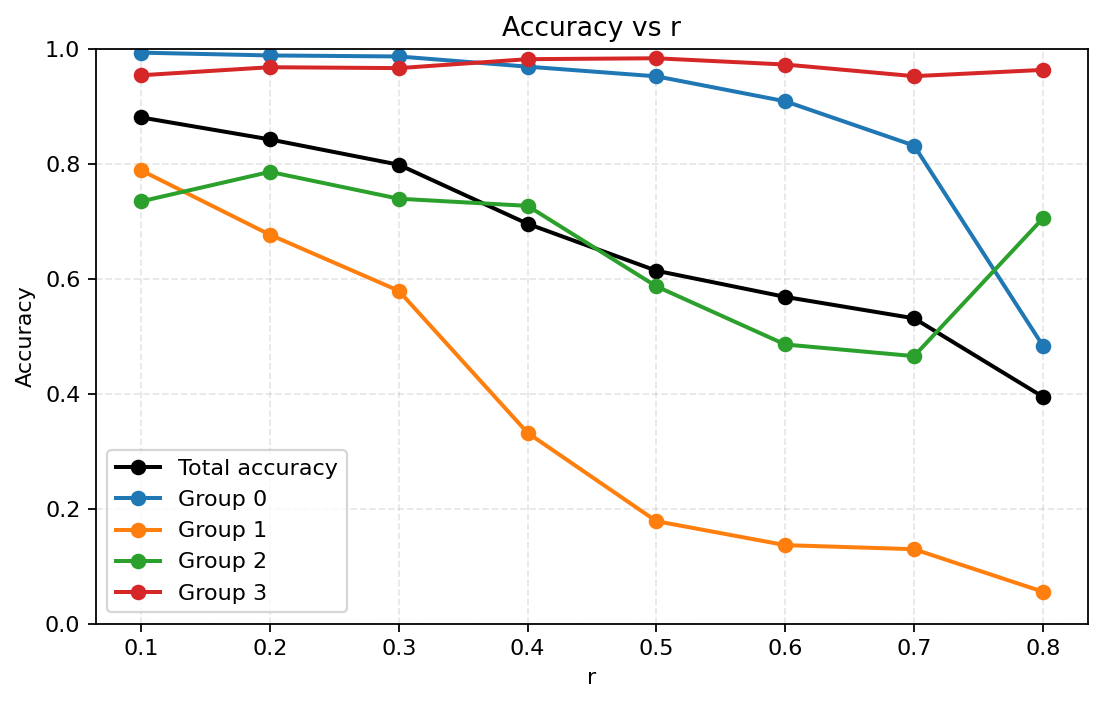

(<Figure size 1120x720 with 1 Axes>,
 <Axes: title={'center': 'Accuracy vs r'}, xlabel='r', ylabel='Accuracy'>)

In [16]:
plot_r_accuracy_lines(accs, save_path = 'pxp viz/acc_linear.png', title = "Linear Layers of Waterbirds Model")

In [17]:
#global_pruning_mask

In [18]:
#global_pruning_mask2

for v in components_relevances.values():
    print(v[0:7])

In [20]:
#print(f'{prune_r},{acc:.3f},{acc_groups[0]:.3f},{acc_groups[1]:.3f},{acc_groups[2]:.3f},{acc_groups[3]:.3f}')#

In [21]:
layer_type

'Linear'

In [22]:
#visualise(global_pruning_mask_combined, r, layer_type)


In [23]:
#components_relevances

In [24]:
#global_pruning_mask

In [25]:
#plot_layer_head_pruned(global_pruning_mask)

In [26]:
#plot_layer_head_heatmap(components_relevances, normalise=30)

In [27]:
def parse_head_mask(head_mask):
    """
    head_mask: OrderedDict, output of pxp
    returns   : dict {int(layer_index) -> list[int(head_idx)]}
    """
    pat = re.compile(r'encoder_layer_(\d+)')
    pruned = {}
    for name, heads in head_mask.items():
        m = pat.search(name)
        if m is None or len(heads) == 0:
            continue
        layer_idx = int(m.group(1))
        pruned[layer_idx] = heads.tolist()
    return pruned

@torch.no_grad()
def zero_vit_heads(model, prunable_head_dict):
    """
    Apply pxp pruning
    Zero Q/K/V and out-proj slices of given heads

    prunable_head_dict: dict {layer_idx -> list[int(head_id)]}
    """
    for idx, block in enumerate(model.encoder.layers):
        if idx not in prunable_head_dict:
            continue

        attn = getattr(block, "self_attention", None)

        if attn is None:
            raise RuntimeError(f"Could not find attention module in layer {idx}")

        hdim = attn.head_dim  # 64
        nheads = attn.num_heads  # 12
        edim = attn.embed_dim  # 768

        in_w = attn.in_proj_weight  # (3*edim, edim)
        in_b = getattr(attn, "in_proj_bias", None)
        out_w = attn.out_proj.weight  # (edim, edim)
        out_b = attn.out_proj.bias

        for h in prunable_head_dict[idx]:
            rows = slice(h * hdim, (h + 1) * hdim)

            # Q, K, V are stacked: [0:edim]   [edim:2*edim]   [2*edim:3*edim]
            for blk in range(3):
                r = slice(rows.start + blk * edim, rows.stop + blk * edim)
                in_w[r].zero_()
                if in_b is not None:
                    in_b[r].zero_()

            out_w[:, rows].zero_()

        if out_b is not None and len(prunable_head_dict[idx]) == nheads:
            out_b.zero_()  # whole attention output is zero

        print(f"layer {idx:2d}: pruned heads {prunable_head_dict[idx]}")

    print("all requested heads have been zero-ed")

In [28]:
if layer_type == 'Softmax':
    checkpoint = torch.load("/home/primmere/ide/dfr/logs/vit_waterbirds.pth", map_location=torch.device('cuda'), weights_only=True)
    model2 = vit_b_16(num_classes = 2)
    model2.load_state_dict(checkpoint)
    mask_dict = parse_head_mask(global_pruning_mask)
    zero_vit_heads(model2, mask_dict)

In [29]:
if save:
    torch.save(model2.state_dict(), new_checkpoint_path)
    print('saved')

In [ ]:
plot_layer_head_heatmap(components_relevances, save_path = 'pxp viz/pxp attn heatmap.png')

In [ ]:
plot_layer_head_pruned(global_pruning_mask)